# Match SpecSim Output Binning to DESI Coadds

See this [specsim pull request](https://github.com/desihub/specsim/pull/125) for more details.

In [1]:
%matplotlib inline

In [2]:
import os

In [3]:
import yaml

In [4]:
from pathlib import Path

In [5]:
import numpy as np
import matplotlib.pyplot as plt

In [6]:
import astropy.table
import astropy.io.fits
import astropy.units as u

In [7]:
import specsim.config
import specsim.simulator

In [8]:
import fitsio

## Coadd Wavelength Grid

Lookup the wavelength grid in a recent iron healpix coadd to establish the binning we want to output from specsim:

In [9]:
#path = Path('/global/cfs/cdirs/desi/spectro/redux/iron/healpix/main/dark/100/10000/')
path = Path('.')
assert path.exists()

In [10]:
hdus = fitsio.FITS(path / 'coadd-main-dark-10000.fits')

In [11]:
limits = np.array([ hdus[f'{band}_WAVELENGTH'].read()[[0,-1]] for band in 'brz' ])
limits

array([[3600., 5800.],
       [5760., 7620.],
       [7520., 9824.]])

In [12]:
binsize = np.array([ np.median(np.diff(hdus[f'{band}_WAVELENGTH'].read())) for band in 'brz' ])
binsize

array([0.8, 0.8, 0.8])

## Camera Definition Arrays

Define some utility functions for loading and inspecting the camera definition arrays used by specsim:

In [13]:
def read_arrays(psf_name, thru_name, path):
    path = Path(path)
    assert path.exists()
    psf = [
        fitsio.read(path / psf_name, ext=f'QUICKSIM-{band}') for band in 'BRZ'
    ]
    thru = [
        fitsio.read(path / thru_name.format(band=band)) for band in 'brz'
    ]
    return psf, thru

In [14]:
def inspect_arrays(psf, thru, xlim=None, save=None):
    fig = plt.figure(figsize=(15, 6))
    for k, band in enumerate('brz'):
        for (data, name) in zip((thru[k], psf[k]), ('thru', ' psf')):
            ranges = ''
            for j, dname in enumerate(data.dtype.names):
                if dname == 'wavelength':
                    continue
                if name == 'thru' and dname != 'throughput':
                    continue
                plt.plot(data['wavelength'], data[dname], '.-' if xlim is not None else '-', c=f'C{j}', label=dname if k==0 else None)
                nonzero = np.where(data[dname] > 0)[0]
                lo,hi = np.round(data['wavelength'][[nonzero[0], nonzero[-1]]], 3)
                ranges += f' {dname}>0 [{lo},{hi}]'
            lo, hi = np.round(data['wavelength'][[0,-1]], 3)
            delta = np.round(np.median(np.diff(data['wavelength'])), 3)
            print(f'{band} {name} {lo} {hi} {delta} {ranges}')
        if xlim is not None:
            plt.xlim(xlim)
    plt.legend()
    plt.grid()
    plt.tight_layout()
    if save:
        plt.savefig(save)

Read the original (non-quickquasars) camera definition arrays in DESIMODEL:

In [15]:
#DESIMODELDATA = Path('/global/common/software/desi/cori/desiconda/20211217-2.0.0/code/desimodel/main/data')
DESIMODELDATA = Path(os.getenv('DESIMODEL')) / 'data'
assert DESIMODELDATA.exists()

In [16]:
psf_orig, thru_orig = read_arrays('specpsf/psf-quicksim.fits', 'throughput/thru-{band}.fits', DESIMODELDATA)

b thru 3533.0 5998.0 0.1  throughput>0 [3533.0,5998.0]
b  psf 3569.0 5949.0 0.5  fwhm_wave>0 [3569.0,5949.0] fwhm_spatial>0 [3569.0,5949.0] neff_spatial>0 [3569.0,5949.0] angstroms_per_row>0 [3569.0,5949.0]
r thru 5564.0 7805.0 0.1  throughput>0 [5564.0,7805.0]
r  psf 5625.0 7741.0 0.5  fwhm_wave>0 [5625.0,7741.0] fwhm_spatial>0 [5625.0,7741.0] neff_spatial>0 [5625.0,7741.0] angstroms_per_row>0 [5625.0,7741.0]
z thru 7360.0 9913.0 0.1  throughput>0 [7360.0,9913.0]
z  psf 7435.0 9834.0 0.5  fwhm_wave>0 [7435.0,9834.0] fwhm_spatial>0 [7435.0,9834.0] neff_spatial>0 [7435.0,9834.0] angstroms_per_row>0 [7435.0,9834.0]


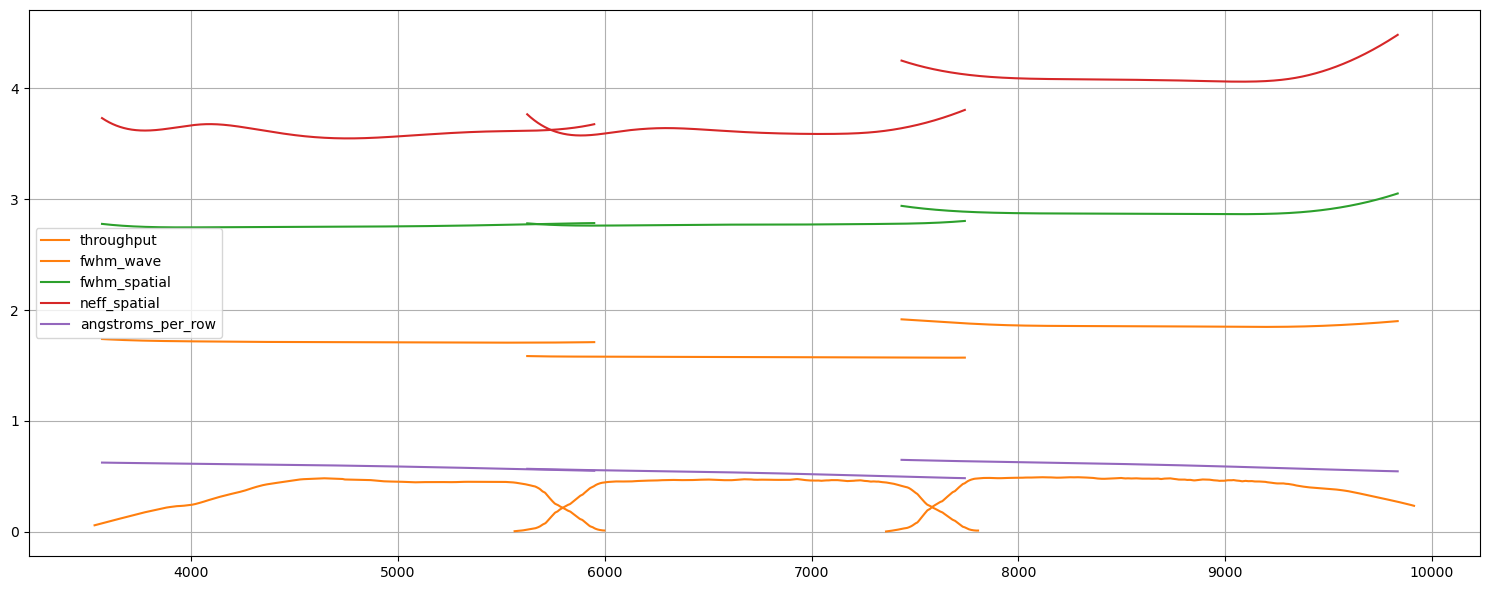

In [17]:
inspect_arrays(psf_orig, thru_orig, save='orig.png')

Read the camera definition arrays currently used by quickquasars:

In [18]:
psf_qq, thru_qq = read_arrays('psf-quicksim-y1.fits', 'thru-{band}_y1measured.fits', '.')

b thru 3600.0 5800.0 0.1  throughput>0 [3600.0,5800.0]
b  psf 3569.0 5949.0 0.5  fwhm_wave>0 [3600.0,5800.0] fwhm_spatial>0 [3600.0,5800.0] neff_spatial>0 [3600.0,5800.0] angstroms_per_row>0 [3600.0,5800.0]
r thru 5760.0 7620.0 0.1  throughput>0 [5760.0,7620.0]
r  psf 5625.0 7741.0 0.5  fwhm_wave>0 [5760.0,7620.0] fwhm_spatial>0 [5760.0,7620.0] neff_spatial>0 [5760.0,7620.0] angstroms_per_row>0 [5760.0,7620.0]
z thru 7520.0 9824.0 0.1  throughput>0 [7520.0,9824.0]
z  psf 7435.0 9834.0 0.5  fwhm_wave>0 [7520.0,9824.0] fwhm_spatial>0 [7520.0,9824.0] neff_spatial>0 [7520.0,9824.0] angstroms_per_row>0 [7520.0,9824.0]


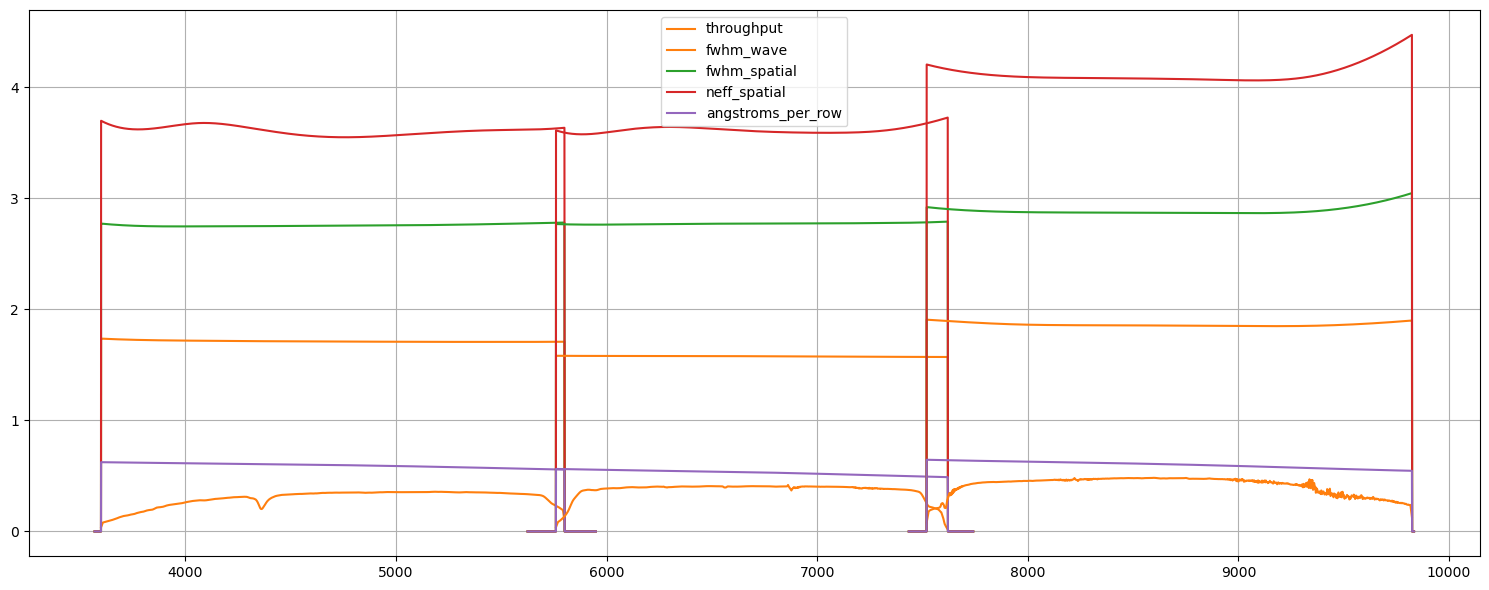

In [19]:
inspect_arrays(psf_qq, thru_qq, save='qq.png')

Write new FITS files with camera arrays interpolated to 0.1A grids that are offset by 0.05A:

In [20]:
def rebin(psf, thru, wmin=3550.05, wmax=9850.05, wstep=0.1,
          psf_new_name='psf-quicksim-rebin.fits', thru_new_name='thru-{band}-rebin.fits'):

    # Define the new grid to use.
    # Not sure why specsim.config uses floor instead of round !?
    nwlen = int(np.round((wmax - wmin) / wstep)) + 1
    wlen_out = wmin + wstep * np.arange(nwlen)
    
    # Define the mask for each band.
    mask = [ (wlen_out <= limits[k,0] - 0.5 * binsize[k]) |
             (wlen_out >= limits[k,1] + 0.5 * binsize[k] + 0.5 * wstep)
            for k in range(3) ]

    # Write the new PSF file.
    psf_new = fitsio.FITS(psf_new_name, 'rw', clobber=True)
    psf_new.write(np.zeros(1))
    psf_new.close()
    for k, band in enumerate('BRZ'):
        data = np.zeros(len(wlen_out), dtype=psf[k].dtype)
        data['wavelength'] = wlen_out
        for name in 'fwhm_wave', 'fwhm_spatial', 'neff_spatial', 'angstroms_per_row':
            # Interpolate to the new grid, using the outermost non-zero values of the input array for extrapolation.
            nonzero = np.where(psf[k][name] > 0)[0]
            data[name] = np.interp(wlen_out, psf[k]['wavelength'][nonzero], psf[k][name][nonzero])
            # Mask values outside the target wavelength coverage.
            data[name][mask[k]] = 0
        table = astropy.table.Table(data, meta=dict(EXTNAME=f'QUICKSIM-{band}'))
        table['wavelength'].unit = u.Angstrom
        table['fwhm_wave'].unit = u.Angstrom
        table['neff_spatial'].unit = u.pixel
        table['angstroms_per_row'].unit = u.Angstrom / u.pixel
        table.write(psf_new_name, append=True)

    # Write the new throughput files.
    for k, band in enumerate('brz'):
        data = np.zeros(len(wlen_out), dtype=thru[k].dtype)
        data['wavelength'] = wlen_out
        for name in 'throughput', 'extinction', 'fiberinput':
            # Interpolate to the new grid, using the outermost non-zero values of the input array for extrapolation.
            nonzero = np.where(thru[k][name] > 0)[0]
            data[name] = np.interp(wlen_out, thru[k]['wavelength'][nonzero], thru[k][name][nonzero])
            # Mask values outside the target wavelength coverage.
            data[name][mask[k]] = 0
        table = astropy.table.Table(data, meta=dict(EXTNAME='THROUGHPUT'))
        table['wavelength'].unit = u.Angstrom
        table.write(thru_new_name.format(band=band), overwrite=True)
        
    return wlen_out

wlen_out = rebin(psf_qq, thru_qq)

Load the rebinned arrays from these newly created files:

In [21]:
psf_new, thru_new = read_arrays('psf-quicksim-rebin.fits', 'thru-{band}-rebin.fits', '.')

Inspect the rebinned arrays:

b thru 3550.05 9850.05 0.1  throughput>0 [3599.65,5800.45]
b  psf 3550.05 9850.05 0.1  fwhm_wave>0 [3599.65,5800.45] fwhm_spatial>0 [3599.65,5800.45] neff_spatial>0 [3599.65,5800.45] angstroms_per_row>0 [3599.65,5800.45]
r thru 3550.05 9850.05 0.1  throughput>0 [5759.65,7620.45]
r  psf 3550.05 9850.05 0.1  fwhm_wave>0 [5759.65,7620.45] fwhm_spatial>0 [5759.65,7620.45] neff_spatial>0 [5759.65,7620.45] angstroms_per_row>0 [5759.65,7620.45]
z thru 3550.05 9850.05 0.1  throughput>0 [7519.65,9824.45]
z  psf 3550.05 9850.05 0.1  fwhm_wave>0 [7519.65,9824.45] fwhm_spatial>0 [7519.65,9824.45] neff_spatial>0 [7519.65,9824.45] angstroms_per_row>0 [7519.65,9824.45]


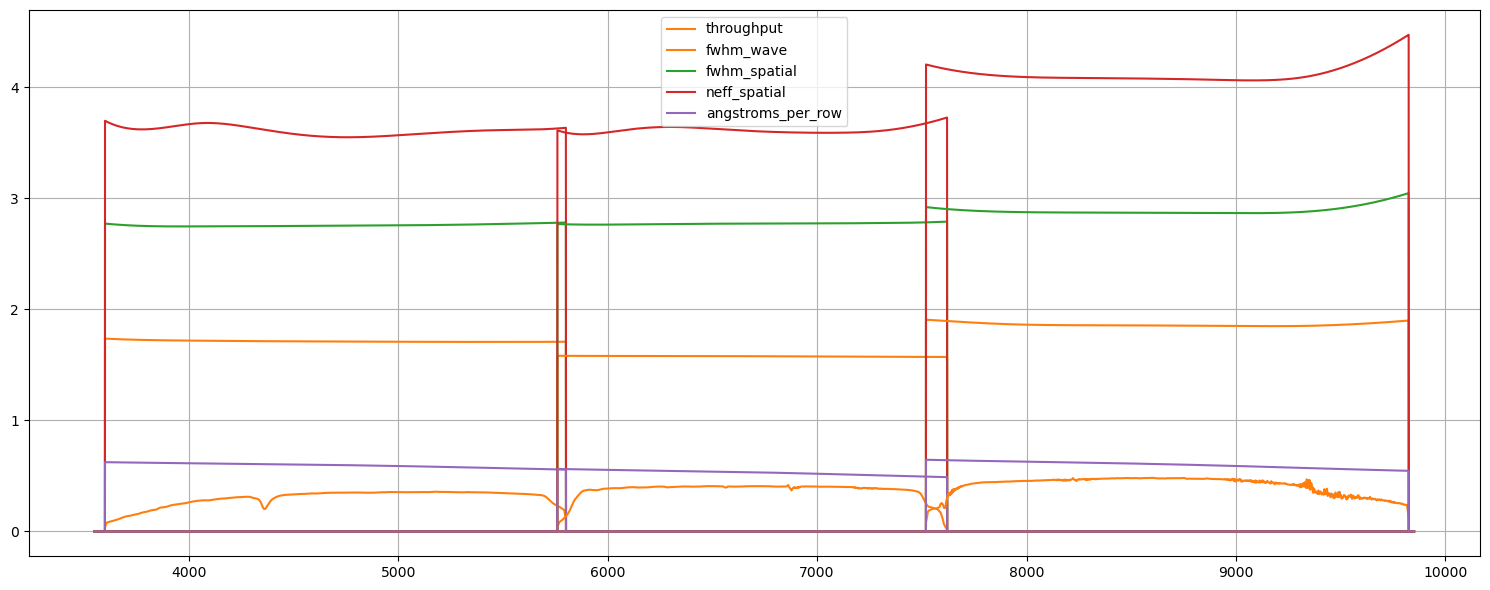

In [22]:
inspect_arrays(psf_new, thru_new)

## SpecSim Output Wavelength Grid

Read a modified version of the DESI config file with the following changes:
 - Offset the `wavelength_grid` min/max values by 0.05 Angstrom to eliminate the 0.05A shift in camera output bin centers
 - Set `output_pixel_size: 0.8 Angstrom` for each camera (was 0.5 Angstrom)
 - Read from the new instrument file generated above:
   - path = `/global/homes/d/dkirkby/DESI/specsim-grid/`
   - psf = `psf-quicksim-new.fits`
   - thru = `thru-[brz]-new.fits`

In [23]:
config = specsim.config.load_config('desi')
#config = specsim.config.load_config('desi-new.yaml')

In [24]:
assert np.array_equal(config.wavelength.value, wlen_out)

In [25]:
desi = specsim.simulator.Simulator(config, num_fibers=1)

Generate a simulated spectrum using the default settings:

In [26]:
desi.simulate()

Verify that we have the desired output wavelength binning:

In [27]:
np.array([ np.round(desi.camera_output[k]['wavelength'][[0, -1]], 3) for k in range(3) ])

array([[3600., 5800.],
       [5760., 7620.],
       [7520., 9824.]])

In [28]:
np.array([ np.median(np.diff(desi.camera_output[k]['wavelength'])) for k in range(3) ])

array([0.8, 0.8, 0.8])

Compare with the target binning:

In [29]:
limits

array([[3600., 5800.],
       [5760., 7620.],
       [7520., 9824.]])

In [30]:
binsize

array([0.8, 0.8, 0.8])